In [1]:
!pip install satlaspretrain_models rasterio segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os

# Change the current working directory. files need to be in a folder called inf367
os.chdir('/content/drive/MyDrive/inf367')

# Verify the change
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/inf367'

In [2]:
# Cell 1: Imports
import os
from datetime import datetime
import numpy as np
import satlaspretrain_models
import torch
import torch.nn as nn
import torch.nn.functional as F
def set_deterministic():
    np.random.seed(123)
    torch.manual_seed(123)
    torch.cuda.manual_seed(123)
    torch.cuda.manual_seed_all(123)
set_deterministic()
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import albumentations as A
from typing import Tuple, Optional, List
import random
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from torchvision import models, transforms
import sys
import itertools
import segmentation_models_pytorch as smp
from shapely.geometry import Polygon
from rasterio.features import rasterize
from typing import Union, List, Dict
import cv2
from collections import defaultdict
from original_utils import *
import matplotlib.pyplot as plt
import json

/opt/anaconda3/envs/satlaspretrain/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
current_dir = os.getcwd()
current_dir

'/Users/bragehs/Documents/INF367A-DeforestationDrivers'

In [6]:
X_train = np.load("data/prepared_data.npy")
y_train = np.load("data/labels.npy")

In [6]:
use_RGB = True

In [8]:
if use_RGB:
    X_train = X_train[:, 1:4, :, :]

In [9]:
print(X_train.shape)
print(y_train.shape)

(176, 3, 1024, 1024)
(176, 1024, 1024)


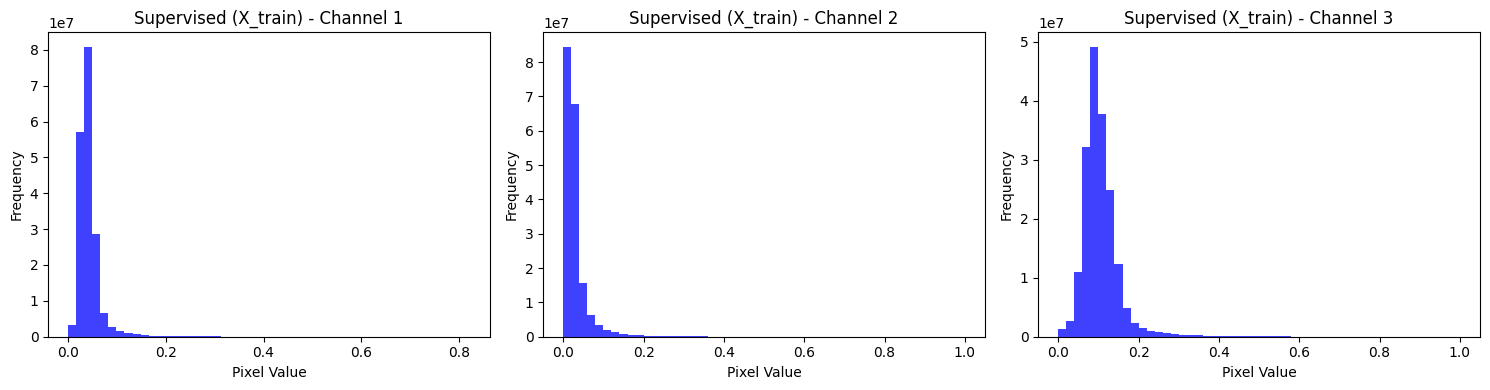

In [10]:
plot_histograms(X_train, 'Supervised (X_train)')

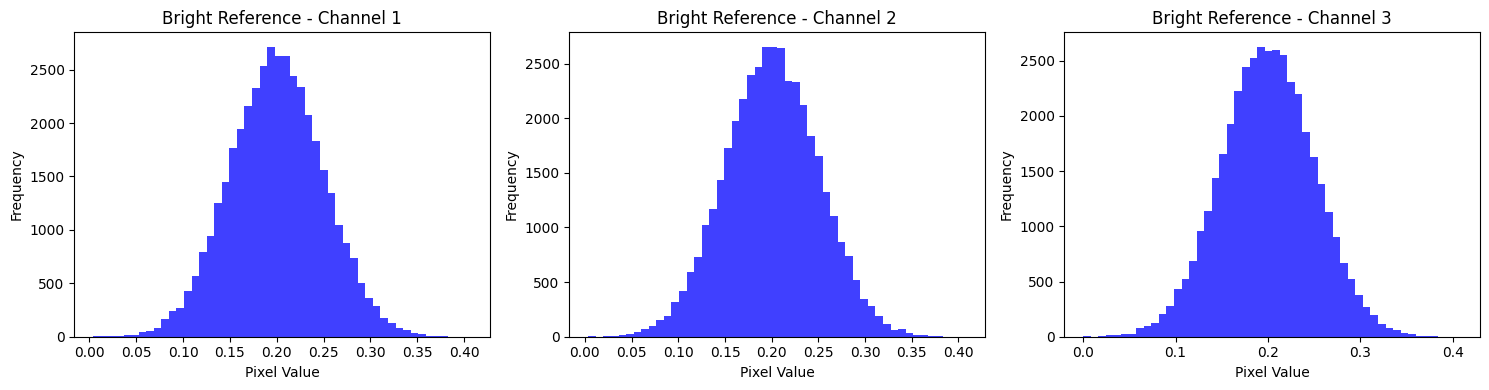

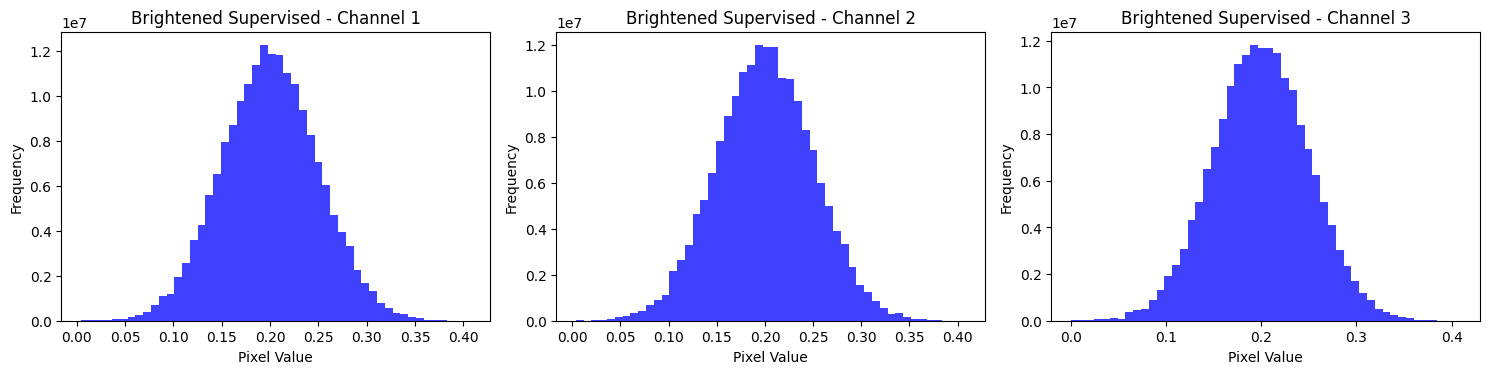

In [11]:
#changing the distribution of the RGB channels, as they seemed very dark when visualizing after normalizing.
#This is not done when using 9 channels, because then we want to use the satlaspretrain normalization template.
if use_RGB:
    bright_reference = create_bright_reference()

    # Plot histogram of reference distribution
    plot_histograms(bright_reference, 'Bright Reference')

    # Match both datasets to this reference
    X_train = histogram_match_images(X_train, bright_reference)
    # Visualize results
    plot_histograms(X_train, 'Brightened Supervised')

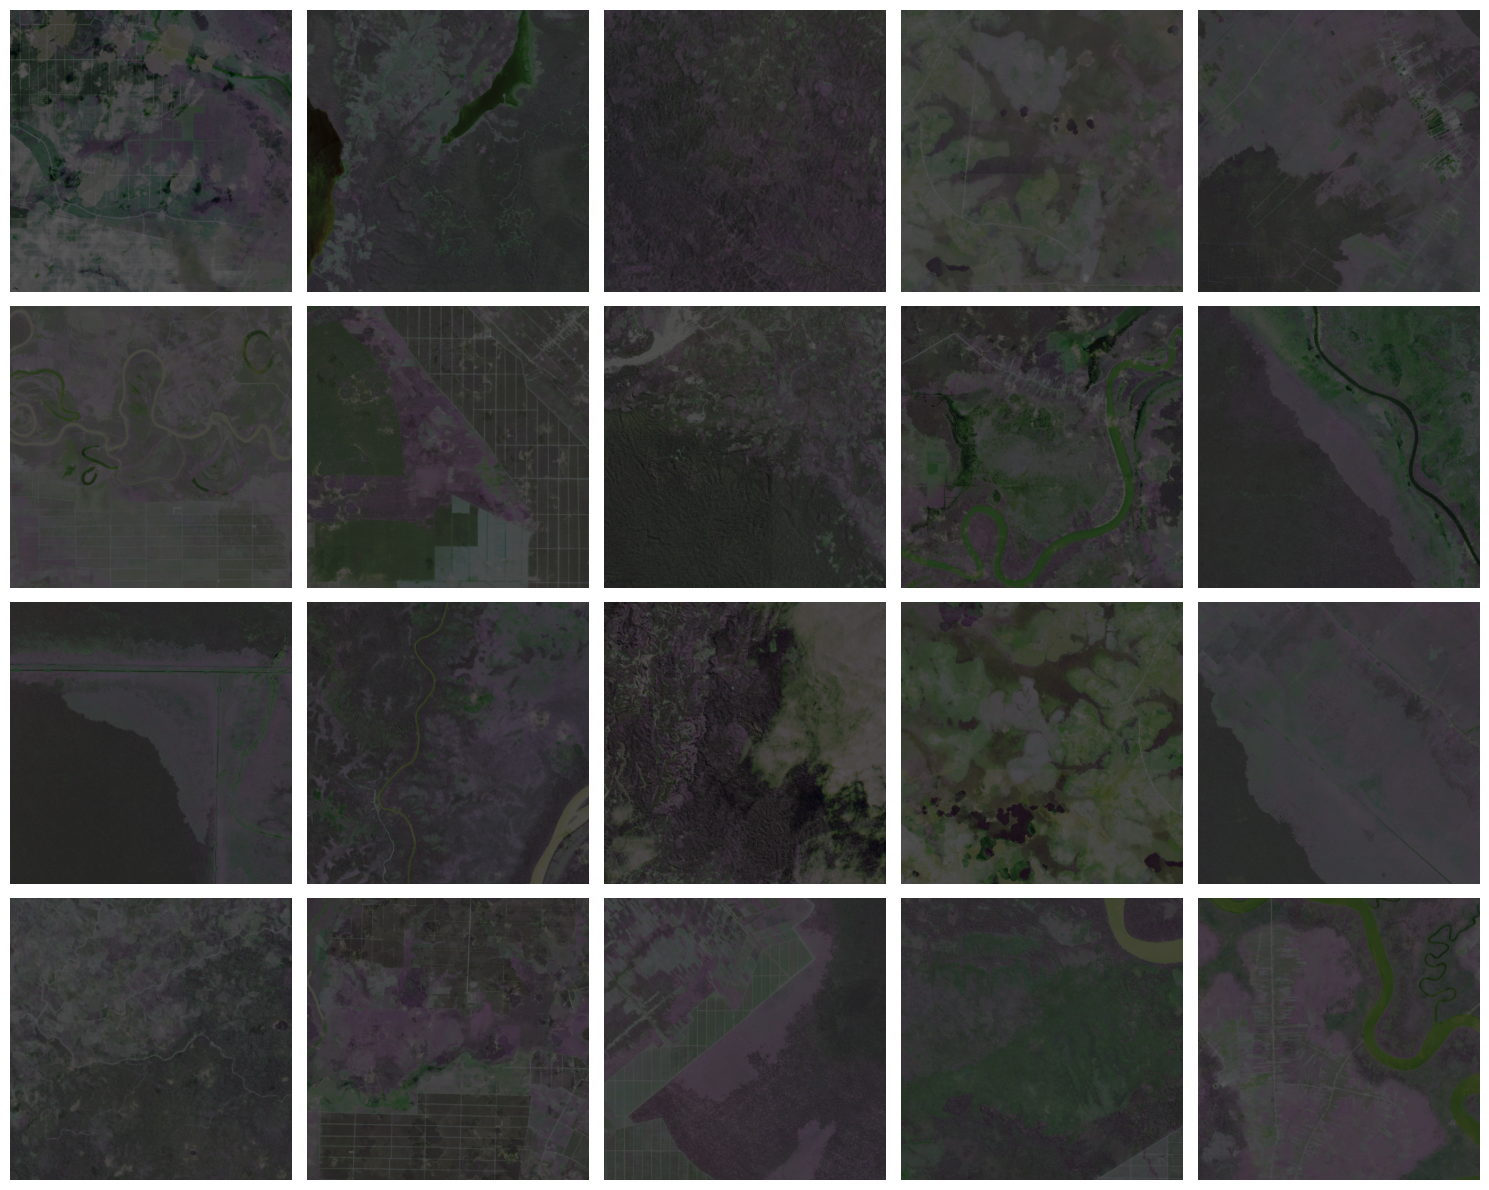

In [12]:
if use_RGB:
  visualize_images(X_train, num_images=20)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=99)

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [8]:
weights_manager = satlaspretrain_models.Weights()
model_url = "Sentinel2_SwinB_SI_RGB" if use_RGB else "Sentinel2_SwinB_SI_MS"
satlas_model = weights_manager.get_pretrained_model(model_url, device=device,
                                                    num_categories = 5,fpn=True)

In [9]:
satlas_model.head = SimpleHead(
    fpn_channels=satlas_model.fpn.out_channels,
    num_categories=5,
)

In [17]:
channels = 3 if use_RGB else 9
dummy_input = torch.randn(1, channels, 256, 256)
output = satlas_model(dummy_input)[0]
print(output.shape)

torch.Size([1, 5, 256, 256])


In [18]:
def train_model(
    model,
    train_images,
    train_labels,
    val_images,
    val_labels,
    num_epochs=20,
    batch_size=4,
    patch_size=256,
    patch_stride=128,
    learning_rate=1e-3,
    weight_decay=0.1,
    num_workers=4,
    delta=1.0,
    device='cuda',
    save_dir=os.getcwd() + "/saved_models",
    save=False,
    use_scheduler = False,
):
    # Create dataloaders
    train_loader, val_loader = create_dataloaders(
        train_images=train_images,
        train_labels=train_labels,
        val_images=val_images,
        val_labels=val_labels,
        batch_size=batch_size,
        patch_size=patch_size,
        patch_stride=patch_stride,
        num_workers=num_workers,
    )

    backbone_params = []
    upsampling_params = []
    fpn_params = []
    head_params = []

    for name, param in model.named_parameters():
        if "backbone" in name:
            backbone_params.append(param)
        elif "upsample" in name or "decoder" in name:
            upsampling_params.append(param)
        elif "fpn" in name:
            fpn_params.append(param)
        elif "head" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    param_groups = [
        {'params': backbone_params, 'lr': learning_rate},
        {'params': fpn_params, 'lr': learning_rate},
        {'params': upsampling_params, 'lr': learning_rate},
        {'params': head_params, 'lr': learning_rate}
    ]
    power = 0.9
    optimizer = torch.optim.AdamW(param_groups, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    decoder_loss = CustomLoss(delta=delta)

    os.makedirs(save_dir, exist_ok=True)

    best_val_f1 = 0
    train_losses = []
    val_losses = []

    # Outer loop for epochs without tqdm to handle nested progress bars
    for epoch in range(num_epochs):
        model.train()
        epoch_total_loss = 0

        # Determine the maximum number of iterations based on all loaders
        num_iter = len(train_loader)
        train_iter = itertools.cycle(train_loader)
        total_train_f1 = 0

        for _ in range(num_iter):
            optimizer.zero_grad()
            loss_total = 0.0

            try:
                model.head.image_branch = False
                images_p, masks = next(train_iter)
                images_p = images_p.to(device)
                masks = masks.to(device)
                output = model(images_p)[0]
                loss = decoder_loss(output, masks)
                loss_total += loss
            except StopIteration:
                loss = torch.tensor(0.0, device=device)

            pred = torch.argmax(output, dim=1).cpu().detach().numpy()
            gt = masks.cpu().detach().numpy()
            train_performance = performance_df_bhw(pred, gt, min_area=0)
            batch_f1 = train_performance.loc['all_images','all_classes']
            total_train_f1 += batch_f1

            if loss_total.item() > 0:
                loss_total.backward()
                optimizer.step()
                epoch_total_loss += loss_total.item()


        #batch_pbar.close()
        avg_epoch_total_loss = epoch_total_loss / num_iter
        train_losses.append(avg_epoch_total_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        total_f1 = 0
        with torch.no_grad():
            for val_data, val_target in val_loader:
                val_data, val_target = val_data.to(device), val_target.to(device)
                val_output = model(val_data)[0]
                v_loss = decoder_loss(val_output, val_target)
                val_loss += v_loss.item()

                pred = torch.argmax(val_output, dim=1).cpu().detach().numpy()
                gt = val_target.cpu().detach().numpy()
                batch_performance = performance_df_bhw(pred, gt, min_area=0)
                batch_f1 = batch_performance.loc['all_images','all_classes']
                total_f1 += batch_f1


        avg_val_loss = val_loss / len(val_loader)
        avg_f1 = total_f1 / len(val_loader)
        avg_f1_train = total_train_f1 / len(train_loader)
        val_losses.append(avg_val_loss)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
        print(f'Training Total Loss: {avg_epoch_total_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Training F1: {avg_f1_train:.4f}')
        print(f'Validation F1: {avg_f1:.4f}\n')

        if use_scheduler:
          scheduler.step(avg_val_loss)

        if (epoch+1) % 5 == 0:
            plot_loss(train_losses, val_losses)

        if avg_f1 > best_val_f1:
            best_val_f1 = avg_f1
            if save is True:
              torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'training_loss': avg_epoch_total_loss,
                  'val_loss': avg_val_loss,
              }, f'{save_dir}/best_model_original.pth')

    return model, best_val_f1

In [19]:
def tune_hyperparameters(
    model,
    train_images,
    train_labels,
    val_images,
    val_labels,
    n_trials=10,
    patch_size=256,
    patch_stride=128,
    batch_size=4,
    num_epochs=10,
    device='cuda',
    random_seed=123,
):
    """
    Tune hyperparameters using random search.

    Args:
        model: The model to tune
        train_images: List of training images
        train_labels: List of training labels
        val_images: List of validation images
        val_labels: List of validation labels
        image_level_images: List of image-level training images
        n_trials: Number of hyperparameter combinations to try
        patch_size: Size of patches to extract from images
        patch_stride: Stride between patches
        batch_size: Batch size for training
        num_epochs: Number of epochs for each trial
        device: Device to run on ('cuda' or 'cpu')
        save_dir: Directory to save models and results
        class_weights: Class weights for loss calculation
        random_seed: Random seed for reproducibility

    Returns:
        best_params: Dictionary of best hyperparameters
        best_model_path: Path to the best model
        results_df: DataFrame containing all trial results
    """
    import random
    import copy
    import gc

    # Set random seeds for reproducibility
    random.seed(random_seed)

    # Use only 20% of training data for faster tuning
    subset_size_train = int(len(train_images) * 0.2)

    # Create random indices for subset selection
    train_indices = random.sample(range(len(train_images)), subset_size_train)

    # Select the subset of data
    subset_train_images = np.array(train_images)[train_indices]
    subset_train_labels = np.array(train_labels)[train_indices]


    print(f"Using {len(subset_train_images)} images for training (20% of original)")

    param_space = {
          'learning_rate': [1e-4, 1e-3, 5e-4],
          'weight_decay': [0.01, 0.05, 0.1, 0.5],
          'delta': [1.0, 1.5, 2.0, 2.75]
      }

    # Initialize tracking variables
    best_f1 = 0
    best_params = None

    # Run random search
    for trial in range(n_trials):
        current_params = {
              'learning_rate': random.choice(param_space['learning_rate']),
              'weight_decay': random.choice(param_space['weight_decay']),
              'delta': random.choice(param_space['delta'])
          }

        print(f"\n\n===== TRIAL {trial+1}/{n_trials} =====")
        print(f"Hyperparameters: {current_params}")

        # Make a deep copy of the model to ensure independence between trials
        #trial_model = type(model)(*model.__init__args__, **model.__init__kwargs__)
        trial_model = copy.deepcopy(model)
        trial_model.load_state_dict(model.state_dict())
        trial_model = trial_model.to(device)

        _, val_f1 = train_model(
              model=trial_model,
              train_images=subset_train_images,
              train_labels=subset_train_labels,
              val_images=val_images,
              val_labels=val_labels,
              num_epochs=num_epochs,
              batch_size=batch_size,
              patch_size=patch_size,
              patch_stride=patch_stride,
              learning_rate=current_params['learning_rate'],
              weight_decay=current_params['weight_decay'],
              delta=current_params['delta'],
              device=device,
          )

        # Update best model if needed
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_params = current_params.copy()

        #trying to clear memory
        trial_model = trial_model.cpu()
        del trial_model
        torch.cuda.empty_cache()
        gc.collect()


        print(f"\nCurrent trial F1: {val_f1:.4f}")
        print(f"Best F1 so far: {best_f1:.4f}")
        print(f"Best parameters so far: {best_params}")

    # Print final results
    print("\n===== HYPERPARAMETER TUNING COMPLETE =====")
    print(f"Best validation F1: {best_f1:.4f}")
    print(f"Best hyperparameters: {best_params}")

    return best_params

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using 28 images for training (20% of original)


===== TRIAL 1/7 =====
Hyperparameters: {'learning_rate': 0.0001, 'weight_decay': 0.1, 'delta': 2.75}


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Epoch 1/10:
Learning rate: 0.0001
Training Total Loss: 4.6153
Validation Loss: 4.8619
Training F1: 0.5033
Validation F1: 0.3896


Epoch 2/10:
Learning rate: 0.0001
Training Total Loss: 3.7128
Validation Loss: 3.8046
Training F1: 0.5233
Validation F1: 0.3748


Epoch 3/10:
Learning rate: 0.0001
Training Total Loss: 3.2744
Validation Loss: 3.7593
Training F1: 0.4854
Validation F1: 0.3433


Epoch 4/10:
Learning rate: 0.0001
Training Total Loss: 3.2540
Validation Loss: 3.5962
Training F1: 0.5005
Validation F1: 0.3616


Epoch 5/10:
Learning rate: 0.0001
Training Total Loss: 3.1298
Validation Loss: 3.4518
Training F1: 0.4701
Validation F1: 0.3431



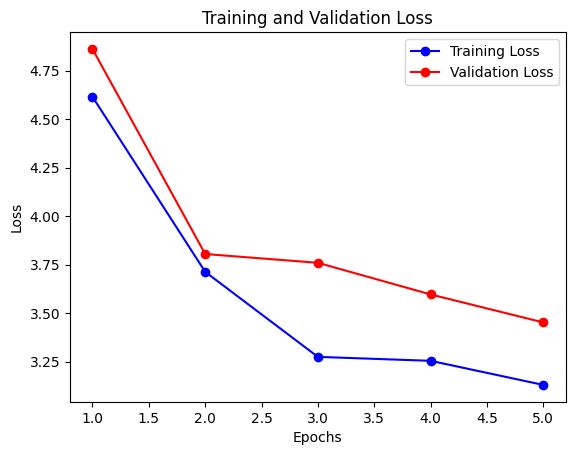


Epoch 6/10:
Learning rate: 0.0001
Training Total Loss: 2.8882
Validation Loss: 3.6916
Training F1: 0.4996
Validation F1: 0.3435


Epoch 7/10:
Learning rate: 0.0001
Training Total Loss: 2.8859
Validation Loss: 3.4206
Training F1: 0.5118
Validation F1: 0.2705


Epoch 8/10:
Learning rate: 0.0001
Training Total Loss: 2.7362
Validation Loss: 3.5269
Training F1: 0.4877
Validation F1: 0.3368


Epoch 9/10:
Learning rate: 0.0001
Training Total Loss: 2.8099
Validation Loss: 3.7018
Training F1: 0.5024
Validation F1: 0.3746


Epoch 10/10:
Learning rate: 0.0001
Training Total Loss: 2.5685
Validation Loss: 3.5261
Training F1: 0.5247
Validation F1: 0.3636



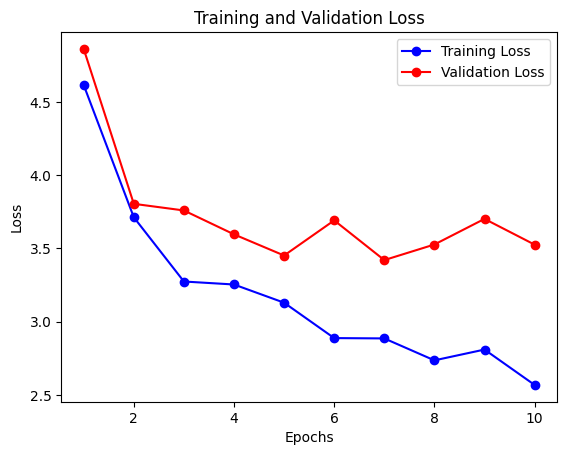


Current trial F1: 0.3896
Best F1 so far: 0.3896
Best parameters so far: {'learning_rate': 0.0001, 'weight_decay': 0.1, 'delta': 2.75}


===== TRIAL 2/7 =====
Hyperparameters: {'learning_rate': 0.0001, 'weight_decay': 0.01, 'delta': 1.0}


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Epoch 1/10:
Learning rate: 0.0001
Training Total Loss: 2.5201
Validation Loss: 2.7183
Training F1: 0.4948
Validation F1: 0.3896


Epoch 2/10:
Learning rate: 0.0001
Training Total Loss: 2.0601
Validation Loss: 2.2382
Training F1: 0.5224
Validation F1: 0.2840


Epoch 3/10:
Learning rate: 0.0001
Training Total Loss: 1.8721
Validation Loss: 2.5749
Training F1: 0.4759
Validation F1: 0.3892


Epoch 4/10:
Learning rate: 0.0001
Training Total Loss: 1.7975
Validation Loss: 2.9430
Training F1: 0.5172
Validation F1: 0.3931


Epoch 5/10:
Learning rate: 0.0001
Training Total Loss: 1.7105
Validation Loss: 1.9055
Training F1: 0.5083
Validation F1: 0.3381



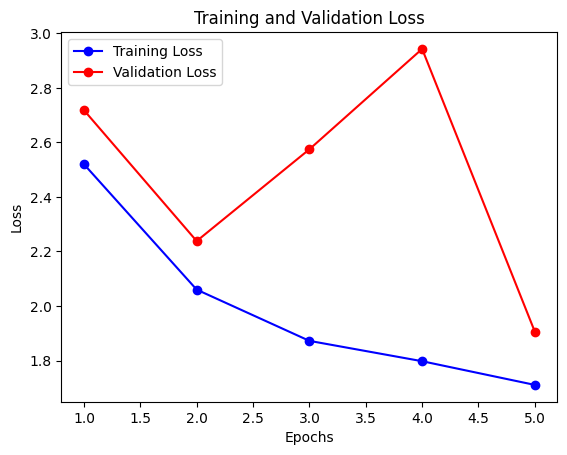


Epoch 6/10:
Learning rate: 0.0001
Training Total Loss: 1.6342
Validation Loss: 1.8776
Training F1: 0.5203
Validation F1: 0.3762


Epoch 7/10:
Learning rate: 0.0001
Training Total Loss: 1.6079
Validation Loss: 1.9038
Training F1: 0.5110
Validation F1: 0.3592


Epoch 8/10:
Learning rate: 0.0001
Training Total Loss: 1.6408
Validation Loss: 1.8634
Training F1: 0.5090
Validation F1: 0.3383


Epoch 9/10:
Learning rate: 0.0001
Training Total Loss: 1.4450
Validation Loss: 1.8941
Training F1: 0.5439
Validation F1: 0.3866


Epoch 10/10:
Learning rate: 0.0001
Training Total Loss: 1.4862
Validation Loss: 1.8933
Training F1: 0.5322
Validation F1: 0.3657



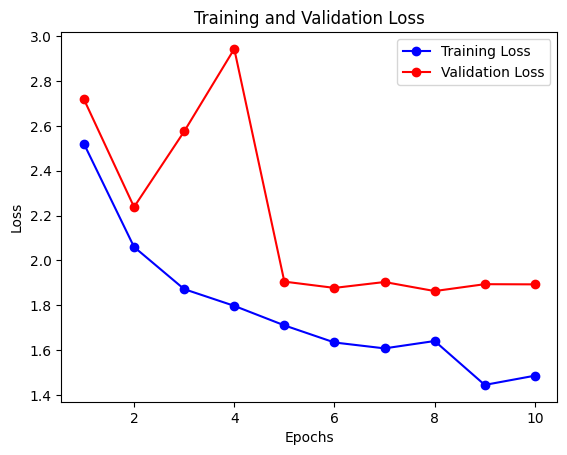


Current trial F1: 0.3931
Best F1 so far: 0.3931
Best parameters so far: {'learning_rate': 0.0001, 'weight_decay': 0.01, 'delta': 1.0}


===== TRIAL 3/7 =====
Hyperparameters: {'learning_rate': 0.0005, 'weight_decay': 0.05, 'delta': 1.5}


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Epoch 1/10:
Learning rate: 0.0005
Training Total Loss: 2.9821
Validation Loss: 3.2377
Training F1: 0.4791
Validation F1: 0.3896


Epoch 2/10:
Learning rate: 0.0005
Training Total Loss: 2.8031
Validation Loss: 3.1534
Training F1: 0.5259
Validation F1: 0.3837


Epoch 3/10:
Learning rate: 0.0005
Training Total Loss: 2.8070
Validation Loss: 3.3464
Training F1: 0.4907
Validation F1: 0.3859


Epoch 4/10:
Learning rate: 0.0005
Training Total Loss: 2.8019
Validation Loss: 3.2144
Training F1: 0.5146
Validation F1: 0.3852


Epoch 5/10:
Learning rate: 0.0005
Training Total Loss: 2.7733
Validation Loss: 3.2922
Training F1: 0.5363
Validation F1: 0.3801



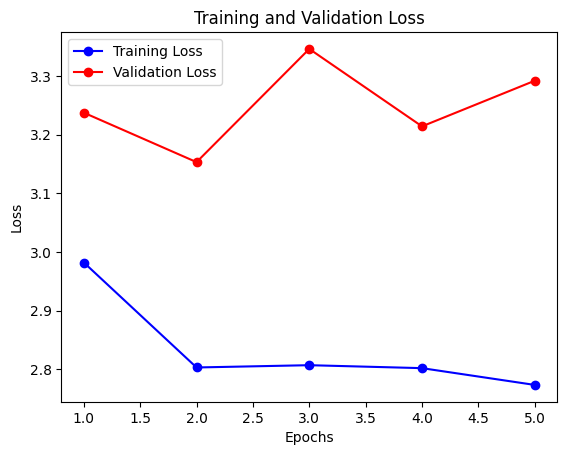


Epoch 6/10:
Learning rate: 0.0005
Training Total Loss: 2.7150
Validation Loss: 3.8560
Training F1: 0.5291
Validation F1: 0.3896


Epoch 7/10:
Learning rate: 0.0005
Training Total Loss: 2.7232
Validation Loss: 3.2245
Training F1: 0.5478
Validation F1: 0.3884


Epoch 8/10:
Learning rate: 0.0005
Training Total Loss: 2.6592
Validation Loss: 3.3210
Training F1: 0.5500
Validation F1: 0.3895


Epoch 9/10:
Learning rate: 5e-05
Training Total Loss: 2.6292
Validation Loss: 3.3643
Training F1: 0.5509
Validation F1: 0.3895


Epoch 10/10:
Learning rate: 5e-05
Training Total Loss: 2.6116
Validation Loss: 3.3108
Training F1: 0.5516
Validation F1: 0.3895



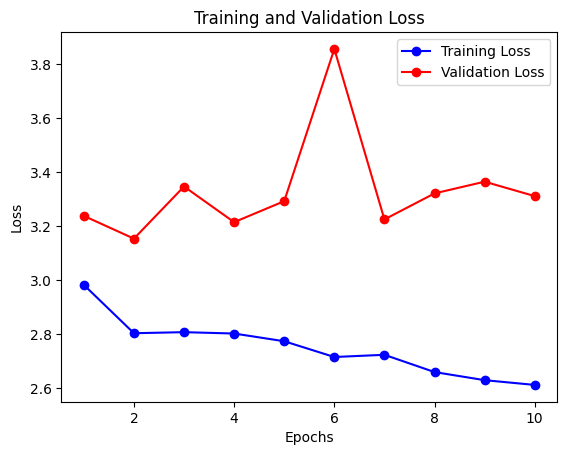


Current trial F1: 0.3896
Best F1 so far: 0.3931
Best parameters so far: {'learning_rate': 0.0001, 'weight_decay': 0.01, 'delta': 1.0}


===== TRIAL 4/7 =====
Hyperparameters: {'learning_rate': 0.0001, 'weight_decay': 0.1, 'delta': 2.75}


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Epoch 1/10:
Learning rate: 0.0001
Training Total Loss: 4.8330
Validation Loss: 4.8536
Training F1: 0.4951
Validation F1: 0.3896


Epoch 2/10:
Learning rate: 0.0001
Training Total Loss: 4.0377
Validation Loss: 4.5837
Training F1: 0.5350
Validation F1: 0.3896


Epoch 3/10:
Learning rate: 0.0001
Training Total Loss: 3.6752
Validation Loss: 3.9567
Training F1: 0.5175
Validation F1: 0.2724


Epoch 4/10:
Learning rate: 0.0001
Training Total Loss: 3.3698
Validation Loss: 4.0634
Training F1: 0.4288
Validation F1: 0.3478


Epoch 5/10:
Learning rate: 0.0001
Training Total Loss: 3.0747
Validation Loss: 3.5517
Training F1: 0.4649
Validation F1: 0.3578



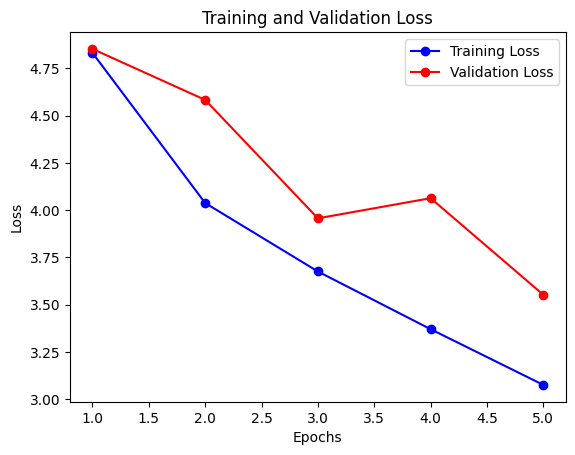


Epoch 6/10:
Learning rate: 0.0001
Training Total Loss: 2.8488
Validation Loss: 3.7447
Training F1: 0.4833
Validation F1: 0.3729


Epoch 7/10:
Learning rate: 0.0001
Training Total Loss: 3.0309
Validation Loss: 3.6383
Training F1: 0.4931
Validation F1: 0.3639


Epoch 8/10:
Learning rate: 0.0001
Training Total Loss: 2.9911
Validation Loss: 3.5457
Training F1: 0.4945
Validation F1: 0.3700


Epoch 9/10:
Learning rate: 0.0001
Training Total Loss: 2.7774
Validation Loss: 3.6140
Training F1: 0.4973
Validation F1: 0.3772


Epoch 10/10:
Learning rate: 0.0001
Training Total Loss: 2.7552
Validation Loss: 3.2899
Training F1: 0.5123
Validation F1: 0.3355



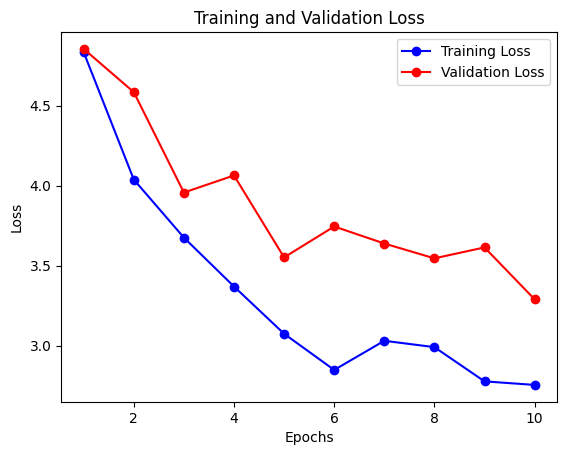


Current trial F1: 0.3896
Best F1 so far: 0.3931
Best parameters so far: {'learning_rate': 0.0001, 'weight_decay': 0.01, 'delta': 1.0}


===== TRIAL 5/7 =====
Hyperparameters: {'learning_rate': 0.0005, 'weight_decay': 0.5, 'delta': 2.0}


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Epoch 1/10:
Learning rate: 0.0005
Training Total Loss: 3.7726
Validation Loss: 3.9026
Training F1: 0.5198
Validation F1: 0.3896


Epoch 2/10:
Learning rate: 0.0005
Training Total Loss: 3.4002
Validation Loss: 3.7793
Training F1: 0.5266
Validation F1: 0.3835


Epoch 3/10:
Learning rate: 0.0005
Training Total Loss: 3.4791
Validation Loss: 4.3843
Training F1: 0.4245
Validation F1: 0.3894


Epoch 4/10:
Learning rate: 0.0005
Training Total Loss: 3.3902
Validation Loss: 4.1024
Training F1: 0.5271
Validation F1: 0.3886


Epoch 5/10:
Learning rate: 0.0005
Training Total Loss: 3.5429
Validation Loss: 3.8530
Training F1: 0.4894
Validation F1: 0.3896



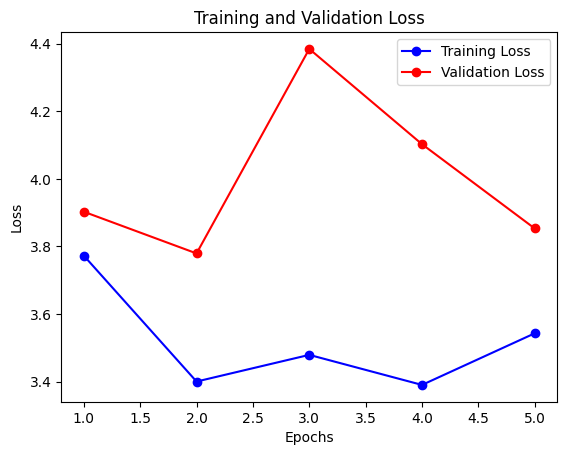


Epoch 6/10:
Learning rate: 0.0005
Training Total Loss: 3.3421
Validation Loss: 4.2997
Training F1: 0.5285
Validation F1: 0.3896


Epoch 7/10:
Learning rate: 0.0005
Training Total Loss: 3.3636
Validation Loss: 3.9538
Training F1: 0.5394
Validation F1: 0.3893


Epoch 8/10:
Learning rate: 0.0005
Training Total Loss: 3.3340
Validation Loss: 3.8950
Training F1: 0.5396
Validation F1: 0.3896


Epoch 9/10:
Learning rate: 5e-05
Training Total Loss: 3.2594
Validation Loss: 3.9838
Training F1: 0.5390
Validation F1: 0.3896


Epoch 10/10:
Learning rate: 5e-05
Training Total Loss: 3.2449
Validation Loss: 4.0138
Training F1: 0.5417
Validation F1: 0.3896



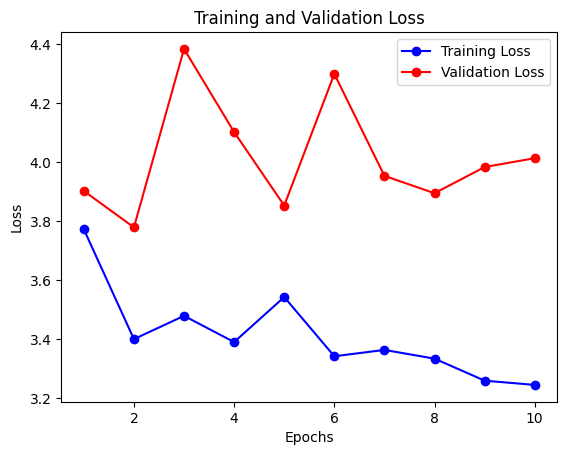


Current trial F1: 0.3896
Best F1 so far: 0.3931
Best parameters so far: {'learning_rate': 0.0001, 'weight_decay': 0.01, 'delta': 1.0}


===== TRIAL 6/7 =====
Hyperparameters: {'learning_rate': 0.001, 'weight_decay': 0.01, 'delta': 2.0}


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Epoch 1/10:
Learning rate: 0.001
Training Total Loss: 4.3620
Validation Loss: 5.3576
Training F1: 0.4236
Validation F1: 0.3896


Epoch 2/10:
Learning rate: 0.001
Training Total Loss: 3.5519
Validation Loss: 4.9820
Training F1: 0.5361
Validation F1: 0.3883


Epoch 3/10:
Learning rate: 0.001
Training Total Loss: 3.4672
Validation Loss: 4.1834
Training F1: 0.5257
Validation F1: 0.3852


Epoch 4/10:
Learning rate: 0.001
Training Total Loss: 3.3316
Validation Loss: 4.3857
Training F1: 0.5276
Validation F1: 0.3896


Epoch 5/10:
Learning rate: 0.001
Training Total Loss: 3.3522
Validation Loss: 3.9785
Training F1: 0.5419
Validation F1: 0.3848



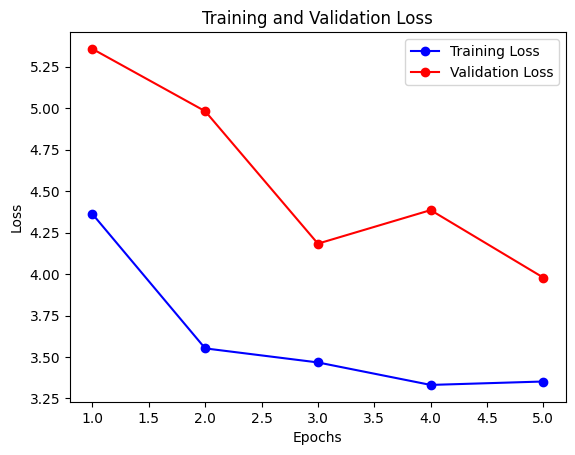


Epoch 6/10:
Learning rate: 0.001
Training Total Loss: 3.3539
Validation Loss: 4.7195
Training F1: 0.5293
Validation F1: 0.3889


Epoch 7/10:
Learning rate: 0.001
Training Total Loss: 3.5388
Validation Loss: 4.3155
Training F1: 0.5405
Validation F1: 0.3882


Epoch 8/10:
Learning rate: 0.001
Training Total Loss: 3.4004
Validation Loss: 4.2265
Training F1: 0.5394
Validation F1: 0.3896


Epoch 9/10:
Learning rate: 0.001
Training Total Loss: 3.3181
Validation Loss: 3.9558
Training F1: 0.5428
Validation F1: 0.3845


Epoch 10/10:
Learning rate: 0.001
Training Total Loss: 3.2215
Validation Loss: 3.9650
Training F1: 0.5520
Validation F1: 0.3896



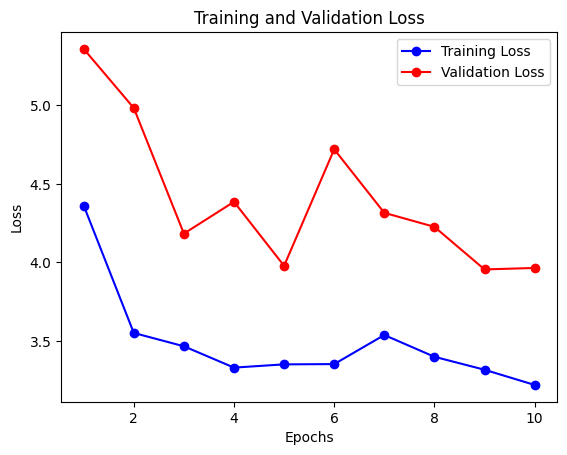


Current trial F1: 0.3896
Best F1 so far: 0.3931
Best parameters so far: {'learning_rate': 0.0001, 'weight_decay': 0.01, 'delta': 1.0}


===== TRIAL 7/7 =====
Hyperparameters: {'learning_rate': 0.001, 'weight_decay': 0.5, 'delta': 1.5}


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Epoch 1/10:
Learning rate: 0.001
Training Total Loss: 3.4621
Validation Loss: 3.6524
Training F1: 0.4677
Validation F1: 0.3769


Epoch 2/10:
Learning rate: 0.001
Training Total Loss: 2.8320
Validation Loss: 3.3872
Training F1: 0.5365
Validation F1: 0.3896


Epoch 3/10:
Learning rate: 0.001
Training Total Loss: 2.8355
Validation Loss: 3.4919
Training F1: 0.5115
Validation F1: 0.3896


Epoch 4/10:
Learning rate: 0.001
Training Total Loss: 2.7799
Validation Loss: 3.1877
Training F1: 0.5431
Validation F1: 0.3888


Epoch 5/10:
Learning rate: 0.001
Training Total Loss: 2.7701
Validation Loss: 3.3716
Training F1: 0.5411
Validation F1: 0.3896



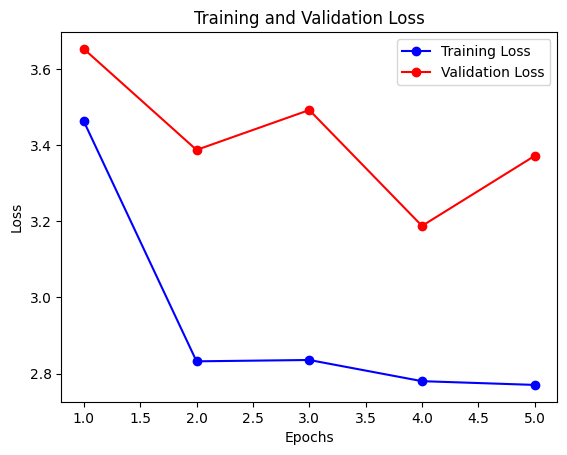


Epoch 6/10:
Learning rate: 0.001
Training Total Loss: 2.7926
Validation Loss: 3.2603
Training F1: 0.5408
Validation F1: 0.3878


Epoch 7/10:
Learning rate: 0.001
Training Total Loss: 2.9047
Validation Loss: 3.1967
Training F1: 0.5377
Validation F1: 0.3896


Epoch 8/10:
Learning rate: 0.001
Training Total Loss: 2.9107
Validation Loss: 3.1917
Training F1: 0.5031
Validation F1: 0.3887


Epoch 9/10:
Learning rate: 0.001
Training Total Loss: 3.4342
Validation Loss: 3.2448
Training F1: 0.5373
Validation F1: 0.3896


Epoch 10/10:
Learning rate: 0.001
Training Total Loss: 2.8771
Validation Loss: 3.6663
Training F1: 0.5104
Validation F1: 0.3893



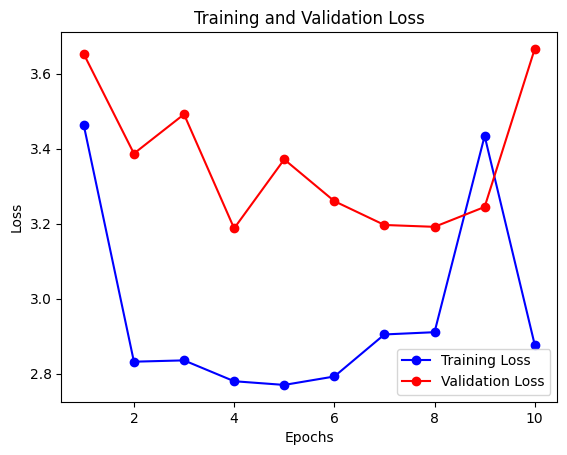


Current trial F1: 0.3896
Best F1 so far: 0.3931
Best parameters so far: {'learning_rate': 0.0001, 'weight_decay': 0.01, 'delta': 1.0}

===== HYPERPARAMETER TUNING COMPLETE =====
Best validation F1: 0.3931
Best hyperparameters: {'learning_rate': 0.0001, 'weight_decay': 0.01, 'delta': 1.0}


In [21]:
best_params = tune_hyperparameters(
    model=satlas_model,
    train_images = X_train,
    train_labels = y_train,
    val_images = X_val,
    val_labels = y_val,
    patch_size = 256,
    patch_stride = 256,
    batch_size = 8,
    n_trials = 7,
    num_epochs = 10,
)

In [22]:
save_dir = os.getcwd()
save_dir

'/content/drive/MyDrive/inf367'

In [23]:
with open(save_dir + "/best_params_original.json", "w") as f:
       json.dump(best_params, f)
       f.flush()  # Flush the data to the file
       os.fsync(f.fileno())  # Ensure data is written to disk

In [24]:
with open(save_dir + "/best_params_original.json", "r") as f:
    loaded_params = json.load(f)
loaded_params

{'learning_rate': 0.0001, 'weight_decay': 0.01, 'delta': 1.0}

In [25]:
import gc

# Invoke garbage collector
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

In [26]:
satlas_model = satlas_model.to(device)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Epoch 1/35:
Learning rate: 0.0001
Training Total Loss: 1.8658
Validation Loss: 1.8177
Training F1: 0.3121
Validation F1: 0.4615


Epoch 2/35:
Learning rate: 0.0001
Training Total Loss: 1.4430
Validation Loss: 1.5818
Training F1: 0.4571
Validation F1: 0.4948


Epoch 3/35:
Learning rate: 0.0001
Training Total Loss: 1.2963
Validation Loss: 1.3534
Training F1: 0.4959
Validation F1: 0.5500


Epoch 4/35:
Learning rate: 0.0001
Training Total Loss: 1.1794
Validation Loss: 1.3585
Training F1: 0.5276
Validation F1: 0.5396


Epoch 5/35:
Learning rate: 0.0001
Training Total Loss: 1.1060
Validation Loss: 1.3086
Training F1: 0.5517
Validation F1: 0.5494



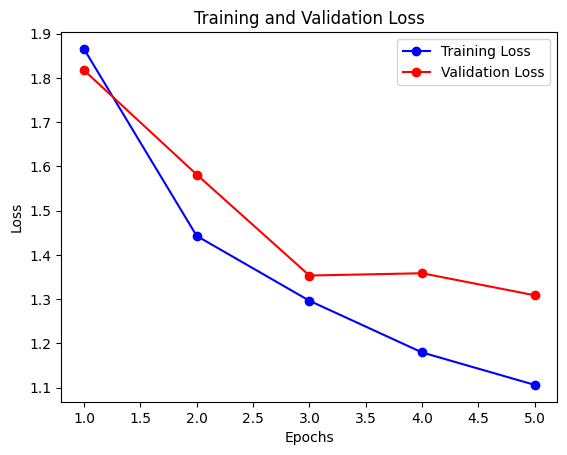


Epoch 6/35:
Learning rate: 0.0001
Training Total Loss: 1.0055
Validation Loss: 1.5101
Training F1: 0.5798
Validation F1: 0.5173


Epoch 7/35:
Learning rate: 0.0001
Training Total Loss: 0.9532
Validation Loss: 1.3642
Training F1: 0.5929
Validation F1: 0.5470


Epoch 8/35:
Learning rate: 0.0001
Training Total Loss: 0.9206
Validation Loss: 1.4500
Training F1: 0.6082
Validation F1: 0.5388


Epoch 9/35:
Learning rate: 0.0001
Training Total Loss: 0.9090
Validation Loss: 1.3342
Training F1: 0.6073
Validation F1: 0.5441


Epoch 10/35:
Learning rate: 0.0001
Training Total Loss: 0.8504
Validation Loss: 1.3902
Training F1: 0.6200
Validation F1: 0.5420



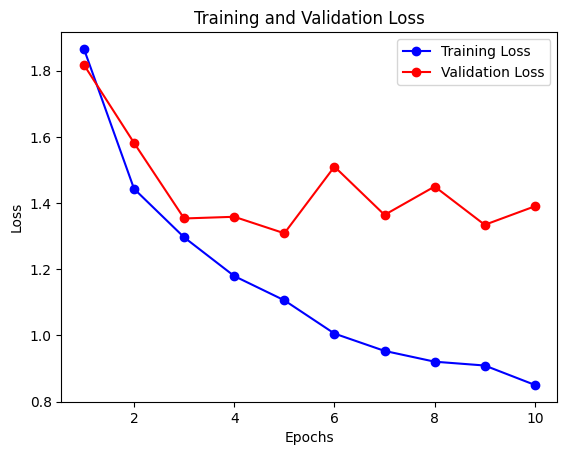


Epoch 11/35:
Learning rate: 0.0001
Training Total Loss: 0.8137
Validation Loss: 1.3546
Training F1: 0.6330
Validation F1: 0.5539


Epoch 12/35:
Learning rate: 1e-05
Training Total Loss: 0.6742
Validation Loss: 1.3617
Training F1: 0.6758
Validation F1: 0.5601


Epoch 13/35:
Learning rate: 1e-05
Training Total Loss: 0.6329
Validation Loss: 1.3859
Training F1: 0.6845
Validation F1: 0.5527


Epoch 14/35:
Learning rate: 1e-05
Training Total Loss: 0.6191
Validation Loss: 1.4358
Training F1: 0.6912
Validation F1: 0.5495


Epoch 15/35:
Learning rate: 1e-05
Training Total Loss: 0.6004
Validation Loss: 1.4625
Training F1: 0.6954
Validation F1: 0.5461



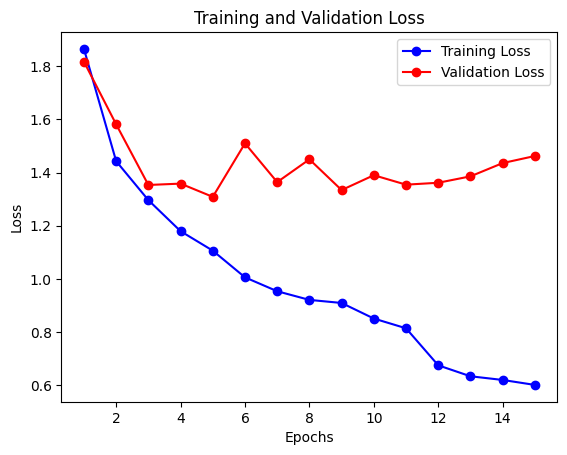


Epoch 16/35:
Learning rate: 1e-05
Training Total Loss: 0.5903
Validation Loss: 1.4398
Training F1: 0.6989
Validation F1: 0.5496


Epoch 17/35:
Learning rate: 1e-05
Training Total Loss: 0.5768
Validation Loss: 1.4388
Training F1: 0.7068
Validation F1: 0.5521


Epoch 18/35:
Learning rate: 1.0000000000000002e-06
Training Total Loss: 0.5667
Validation Loss: 1.4327
Training F1: 0.7117
Validation F1: 0.5548


Epoch 19/35:
Learning rate: 1.0000000000000002e-06
Training Total Loss: 0.5595
Validation Loss: 1.4304
Training F1: 0.7082
Validation F1: 0.5582


Epoch 20/35:
Learning rate: 1.0000000000000002e-06
Training Total Loss: 0.5567
Validation Loss: 1.4263
Training F1: 0.7126
Validation F1: 0.5553



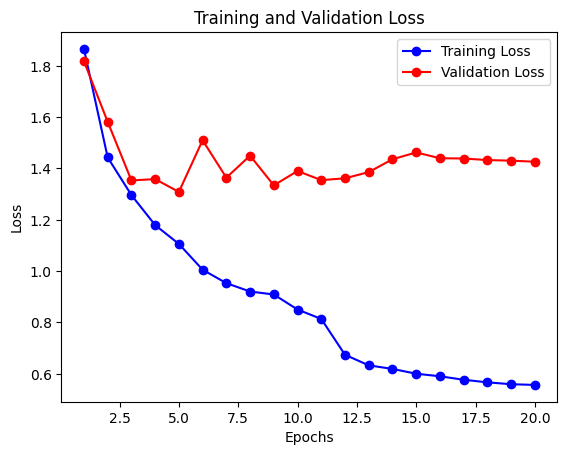


Epoch 21/35:
Learning rate: 1.0000000000000002e-06
Training Total Loss: 0.5572
Validation Loss: 1.4194
Training F1: 0.7099
Validation F1: 0.5566


Epoch 22/35:
Learning rate: 1.0000000000000002e-06
Training Total Loss: 0.5550
Validation Loss: 1.4436
Training F1: 0.7113
Validation F1: 0.5562


Epoch 23/35:
Learning rate: 1.0000000000000002e-06
Training Total Loss: 0.5544
Validation Loss: 1.4433
Training F1: 0.7139
Validation F1: 0.5542


Epoch 24/35:
Learning rate: 1.0000000000000002e-07
Training Total Loss: 0.5515
Validation Loss: 1.4403
Training F1: 0.7147
Validation F1: 0.5551


Epoch 25/35:
Learning rate: 1.0000000000000002e-07
Training Total Loss: 0.5520
Validation Loss: 1.4399
Training F1: 0.7146
Validation F1: 0.5553



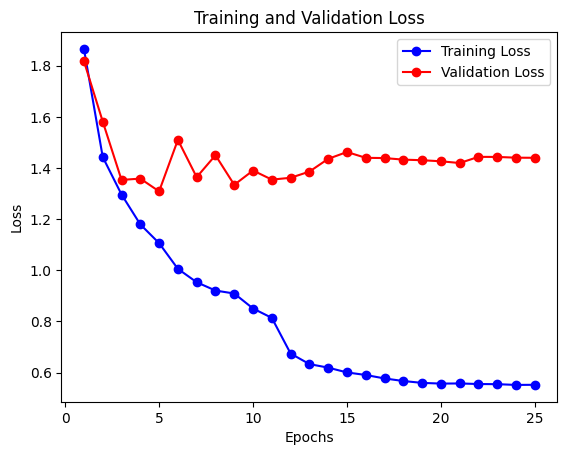


Epoch 26/35:
Learning rate: 1.0000000000000002e-07
Training Total Loss: 0.5527
Validation Loss: 1.4402
Training F1: 0.7114
Validation F1: 0.5552


Epoch 27/35:
Learning rate: 1.0000000000000002e-07
Training Total Loss: 0.5534
Validation Loss: 1.4403
Training F1: 0.7123
Validation F1: 0.5553


Epoch 28/35:
Learning rate: 1.0000000000000002e-07
Training Total Loss: 0.5492
Validation Loss: 1.4414
Training F1: 0.7162
Validation F1: 0.5554


Epoch 29/35:
Learning rate: 1.0000000000000002e-07
Training Total Loss: 0.5500
Validation Loss: 1.4413
Training F1: 0.7143
Validation F1: 0.5555


Epoch 30/35:
Learning rate: 1.0000000000000004e-08
Training Total Loss: 0.5553
Validation Loss: 1.4414
Training F1: 0.7159
Validation F1: 0.5555



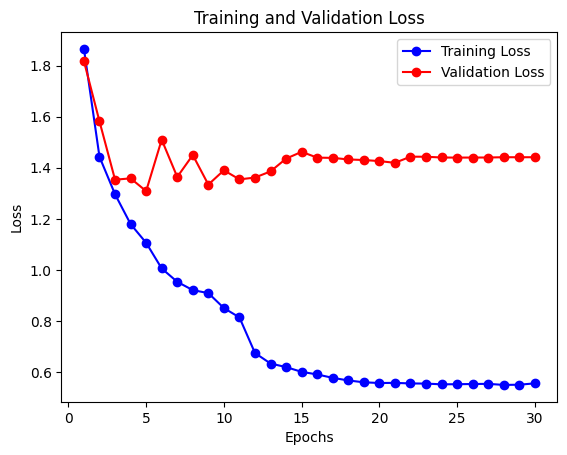


Epoch 31/35:
Learning rate: 1.0000000000000004e-08
Training Total Loss: 0.5505
Validation Loss: 1.4417
Training F1: 0.7156
Validation F1: 0.5555


Epoch 32/35:
Learning rate: 1.0000000000000004e-08
Training Total Loss: 0.5498
Validation Loss: 1.4417
Training F1: 0.7137
Validation F1: 0.5555


Epoch 33/35:
Learning rate: 1.0000000000000004e-08
Training Total Loss: 0.5537
Validation Loss: 1.4419
Training F1: 0.7114
Validation F1: 0.5555


Epoch 34/35:
Learning rate: 1.0000000000000004e-08
Training Total Loss: 0.5496
Validation Loss: 1.4421
Training F1: 0.7144
Validation F1: 0.5554


Epoch 35/35:
Learning rate: 1.0000000000000004e-08
Training Total Loss: 0.5498
Validation Loss: 1.4421
Training F1: 0.7134
Validation F1: 0.5554



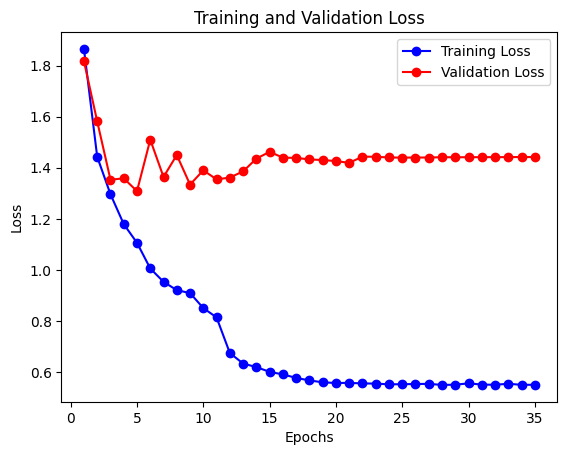

In [27]:
final_model, final_f1 = train_model(
    model=satlas_model,
    train_images=X_train,
    train_labels=y_train,
    val_images=X_val,
    val_labels=y_val,
    num_epochs=35,
    batch_size = 8,
    learning_rate=loaded_params['learning_rate'],
    weight_decay=loaded_params['weight_decay'],
    delta=loaded_params['delta'],
    save = True,
    use_scheduler=True,
    device=device,
    )

In [10]:
def load_model(model, save_path, model_name):

    weights_path = save_path + model_name
    state = torch.load(weights_path, map_location=torch.device('cuda'))
    model.load_state_dict(state['model_state_dict'], strict=False)
    print(f"epoch: {state['epoch']}, training loss: {state['training_loss']}, validation loss: {state['val_loss']}")
    model.eval()

    return model

In [12]:
loaded_model = load_model(satlas_model, '/content/drive/MyDrive/inf367/saved_models/', "best_model_original.pth")

epoch: 11, training loss: 0.674201431901926, validation loss: 1.361734994433143


In [20]:
loaded_model.to(device)

Model(
  (backbone): SwinBackbone(
    (backbone): SwinTransformer(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (1): Sequential(
          (0): SwinTransformerBlockV2(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftedWindowAttentionV2(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (cpb_mlp): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=4, bias=False)
              )
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
            (norm2): LayerNorm((128,), eps=1e-05, element

In [13]:
X_test = np.load("data/test_data.npy")

In [14]:
if use_RGB:
    X_test = X_test[:, 1:4, :, :]

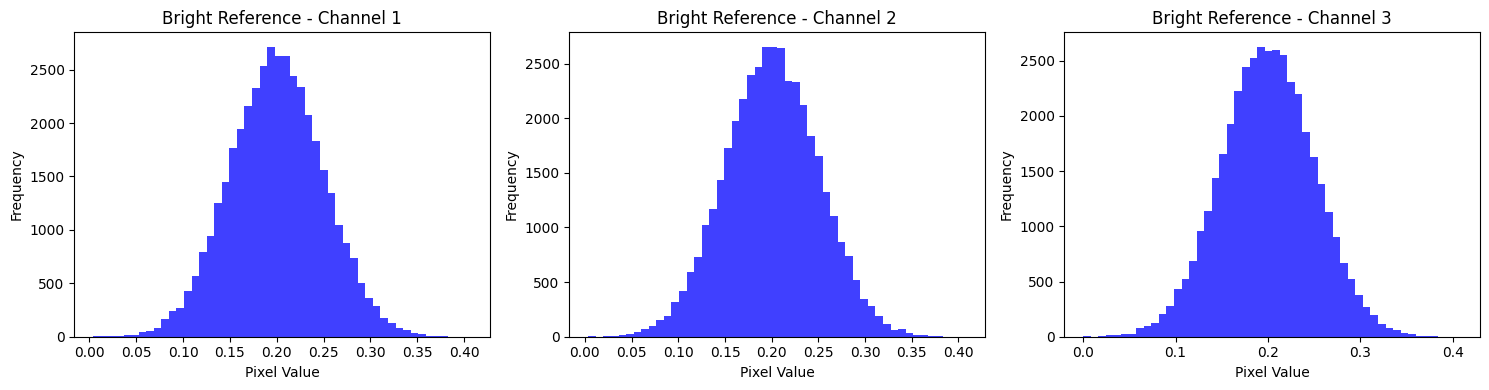

In [15]:
bright_reference = create_bright_reference()
plot_histograms(bright_reference, 'Bright Reference')
X_test = histogram_match_images(X_test, bright_reference)

In [18]:
test_dataset = TestDataset(X_test, patch_size=256, stride=128, tta=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [21]:
preds = predict_probs(loaded_model, test_dataloader, device = device)

Running inference: 100%|██████████| 362/362 [01:20<00:00,  4.49it/s]


In [22]:
positions = test_dataloader.dataset.positions  # Get positions from dataset
stitched_tensors = stitch_patches(preds, positions, patch_size=256)

In [23]:
post_processed = post_process_torch(
    stitched_tensors,
    kernel_size=5,
    min_size=1000,
    apply_smoothing=True,
    remove_small_objects=True,
    fill_enclosed=True,
    smooth_boundaries=True,
    connect_logging=False,
    min_logging_size=25,
    logging_thickness=0  # Set to 0 for minimum thickness, 1 for slightly thicker
)

In [24]:
polygons = converter(post_processed)

Converting tensor to polygons for image 0
(1024, 1024)
Converting tensor to polygons for image 1
(1024, 1024)
Converting tensor to polygons for image 2
(1024, 1024)
Converting tensor to polygons for image 3
(1024, 1024)
Converting tensor to polygons for image 4
(1024, 1024)
Converting tensor to polygons for image 5
(1024, 1024)
Converting tensor to polygons for image 6
(1024, 1024)
Converting tensor to polygons for image 7
(1024, 1024)
Converting tensor to polygons for image 8
(1024, 1024)
Converting tensor to polygons for image 9
(1024, 1024)
Converting tensor to polygons for image 10
(1024, 1024)
Converting tensor to polygons for image 11
(1024, 1024)
Converting tensor to polygons for image 12
(1024, 1024)
Converting tensor to polygons for image 13
(1024, 1024)
Converting tensor to polygons for image 14
(1024, 1024)
Converting tensor to polygons for image 15
(1024, 1024)
Converting tensor to polygons for image 16
(1024, 1024)
Converting tensor to polygons for image 17
(1024, 1024)
Co

In [25]:
write_json(polygons, 'vanilla_rgb')

In [28]:
from google.colab import runtime
runtime.unassign()